In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

c:\Users\Fitsum\AppData\Local\Programs\Python\Python310\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [6]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)

# Set numerical columns as float32
for col in df.columns:
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas dataset
# Assuming 'unit_nr' is the item_id and 'time_cycles' is the time column. 
# Also assuming that one of the sensor readings will be used as the target for predictions. 
# Replace 's_1' with the actual target column name
dataset = PandasDataset.from_long_dataframe(
    df, 
    target="s_1",  # Replace with the actual target column name
    item_id="unit_nr",
    timestamp="time_cycles"
)

In [13]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="s_1", item_id="unit_nr")

backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device('cuda:0') # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [14]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
len(forecasts)

NameError: name 'forecasts' is not defined

In [ ]:
forecasts[0].samples.shape

(100, 24)

In [ ]:
print(forecasts)

[gluonts.model.forecast.SampleForecast(info=None, item_id='1.0', samples=array([[23.165474, 23.562399, 23.163643, ..., 22.972925, 23.503477,
        24.050964],
       [22.922009, 24.145088, 23.336685, ..., 22.8136  , 24.069765,
        21.583075],
       [23.880108, 22.449118, 23.119648, ..., 25.135206, 23.2458  ,
        24.222912],
       ...,
       [22.806889, 23.873545, 24.062574, ..., 22.984877, 22.630024,
        24.621744],
       [22.847084, 22.720829, 24.20329 , ..., 22.56989 , 22.074709,
        23.116514],
       [23.054947, 23.349619, 23.259527, ..., 23.042023, 23.653568,
        23.672663]], dtype=float32), start_date=Period('1970-01-01 00:00:00.000000169', 'N')), gluonts.model.forecast.SampleForecast(info=None, item_id='2.0', samples=array([[22.479616, 22.573225, 23.35329 , ..., 22.807985, 23.993885,
        25.194843],
       [21.394136, 23.452473, 21.408484, ..., 24.700598, 23.130962,
        23.258698],
       [22.479706, 23.3586  , 24.000494, ..., 23.892534, 25.3523

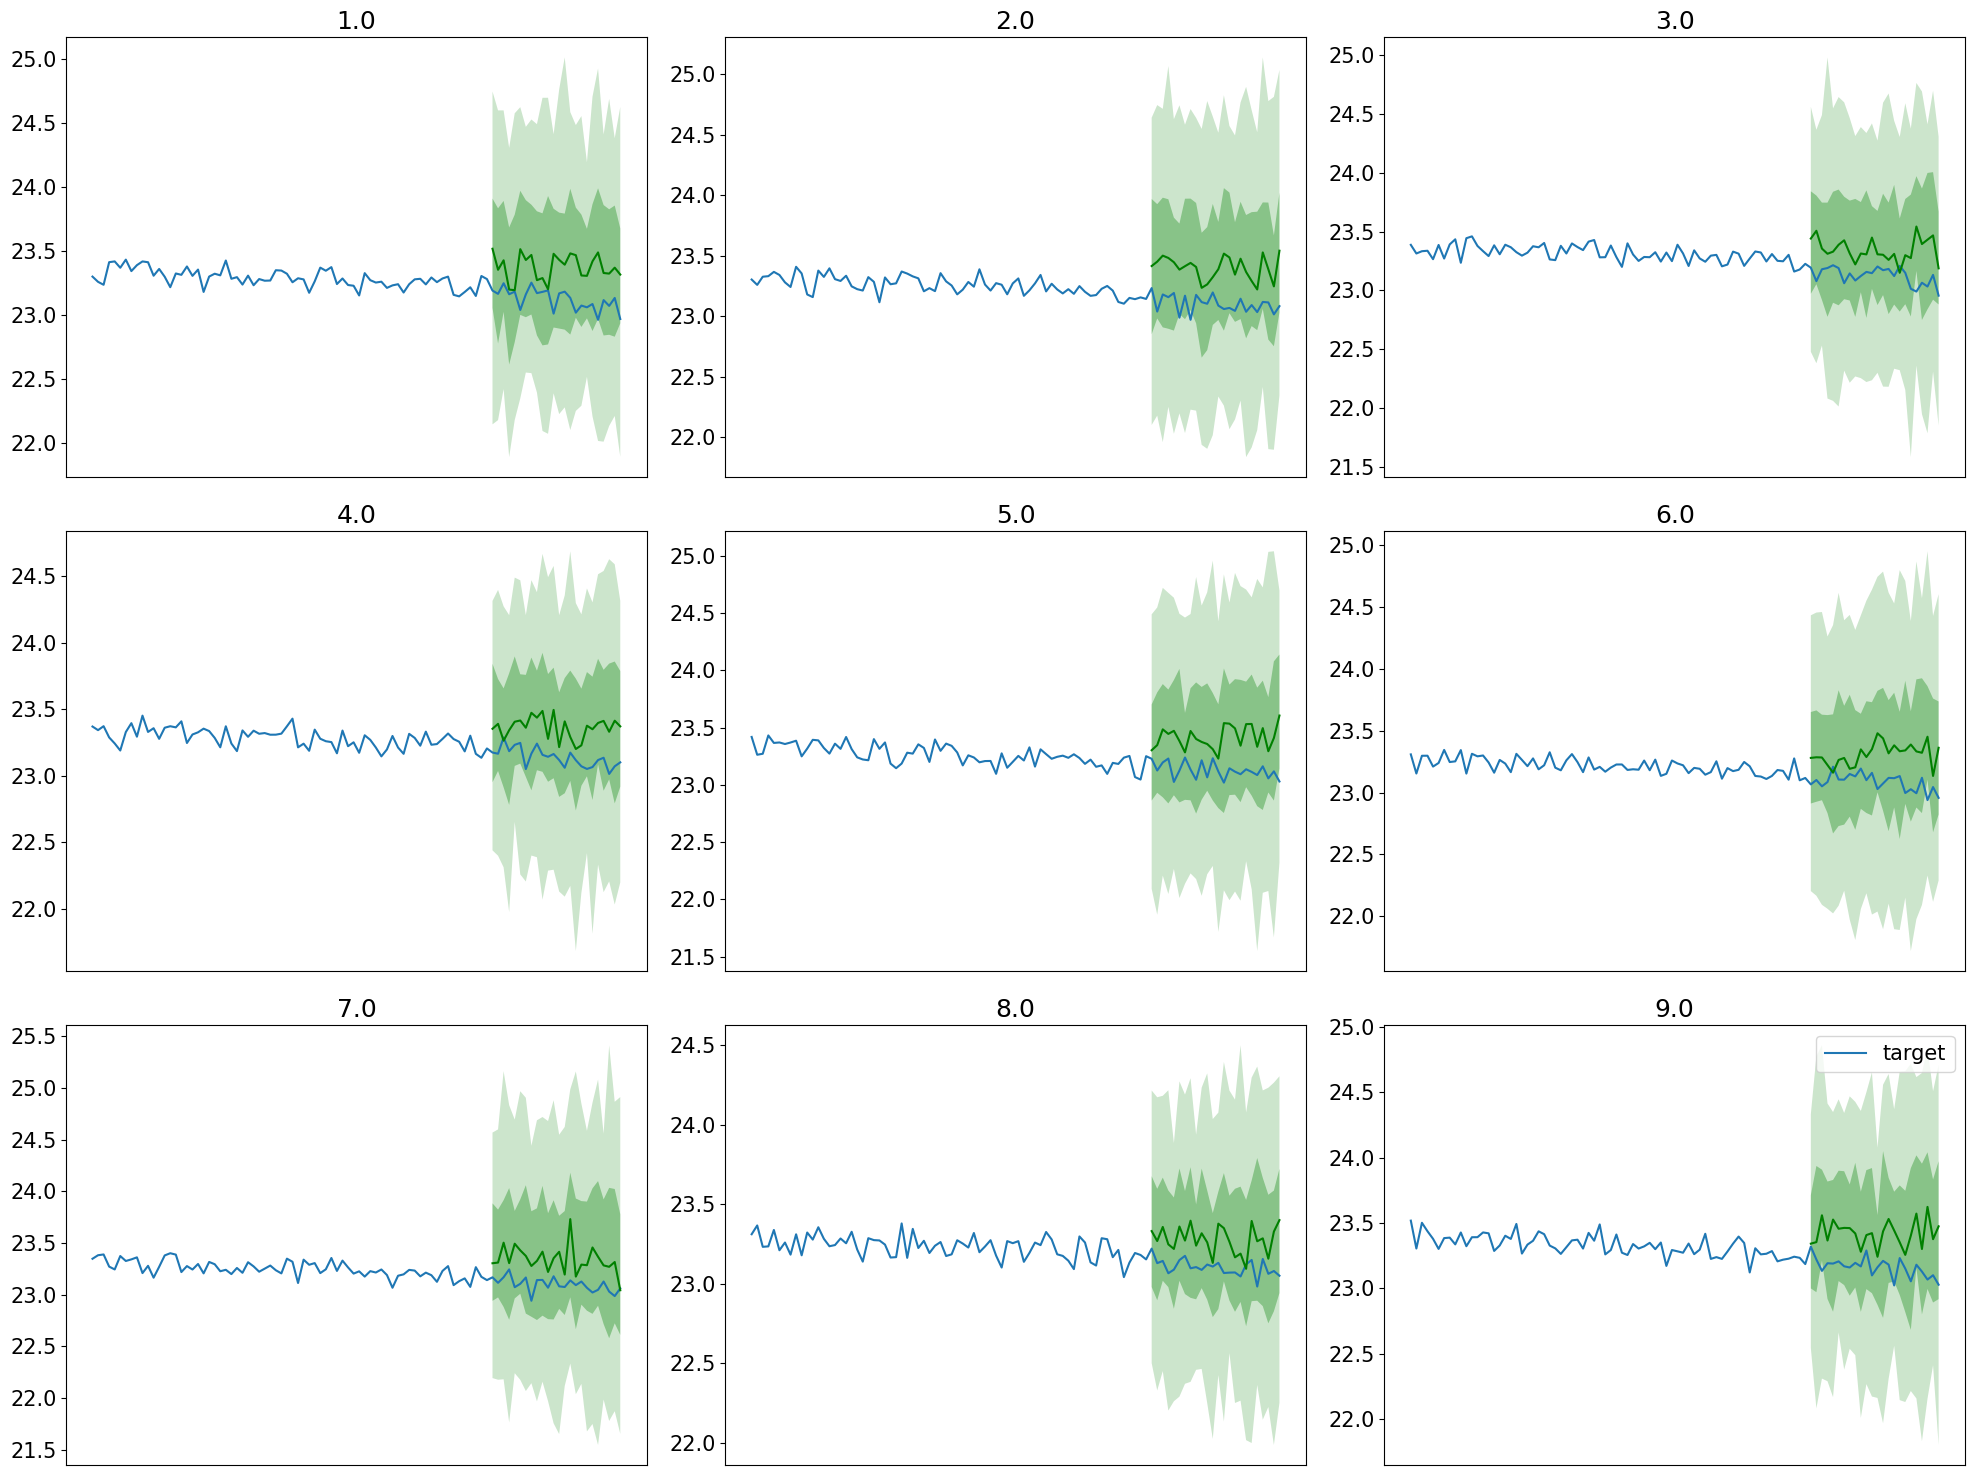

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()